In [1]:
import cv2
from matplotlib import pyplot as plt
import numpy as np
import os
from tqdm.notebook import tqdm
from vidgear.gears import VideoGear

import sys
sys.path.insert(0, '../../')
from models_inference.yolo_main_wrapper import YOLOONNXInference, convert_yoloonnx_detections_to_united_list
from utils.distance_utils import \
    get_intrinsics, calcle_distance_line, transform_to_formula_angle

%matplotlib inline

In [39]:
def plot_frame(image: np.ndarray, figsize=(8, 6), title=None):
    plt.figure(figsize=figsize)
    if title is not None:
        plt.title(title, fontsize=12)
    plt.imshow(image)
    
    
def render_dist_frame(image, train_asset, matrix, warp_size, dets: list, dist_info = None):
    wout = cv2.warpPerspective(image.copy(), matrix, warp_size, borderMode=cv2.BORDER_CONSTANT)
    padded = np.pad(
        wout,
        (
            (0, train_asset.shape[0] - int(train_asset.shape[0] * 0.2)),
            (0, 0),
            (0, 0)
        ),
        # 'linear_ramp',
        'constant',
        constant_values=0
    )
    y1 = wout.shape[0] - int(train_asset.shape[0] * 0.2)
    x1 = wout.shape[1] // 2 - train_asset.shape[1] // 2 
    padded[
        y1:y1+train_asset.shape[0], x1:x1+train_asset.shape[1]
    ][train_asset[..., 0] > 0] = train_asset[..., :3][train_asset[..., 0] > 0]
    

    if dist_info is not None:
        lines_colors = ((200, 20, 10), (200, 200, 10), (20, 200, 10))
        
        for line_i, line_d in enumerate(dist_info['distances']):
            line = calcle_distance_line(
                line_d, 
                image.shape[:2], 
                dist_info['h'], 
                dist_info['K'], 
                dist_info['angle']
            )
            line_points = np.array([[x, line[x]] for x in range(len(line))])
            line_pts = line_points.astype(np.float32)[:, None]
            warped_line_pts = cv2.perspectiveTransform(line_pts, mat).squeeze(1)
            
            warped_full_x = np.arange(warped_line_pts[:, 0].min(), warped_line_pts[:, 0].max(), 1)
            yinterp = np.interp(
                warped_full_x, 
                warped_line_pts[:, 0], warped_line_pts[:, 1]
            )
            warped_line_pts = np.stack((warped_full_x, yinterp), axis=1)
            
            for i, j in warped_line_pts.tolist():
                padded = cv2.circle(padded, (int(i), int(j)), 9, lines_colors[line_i], -1)

    if len(dets) > 0:
        pts = []
        for det in dets:
            x1, y1, x2, y2 = det[0]
            xc = (x2 + x1) / 2
            yc = y2
            pts.append([xc, yc])

        pts = np.array(pts).astype(np.float32)[:, None]
        warped_pts = cv2.perspectiveTransform(pts, mat).squeeze(1)

        for p in warped_pts:
            padded = cv2.circle(padded, (int(p[0]), int(p[1])), 30, (20, 200, 50), 15)
    
    return padded


def draw_lines(image, matrix, angle, regions=[5, 6, 7], camera_h=2):
    assert len(regions) == 3
    res = image.copy()
    _angle = transform_to_formula_angle(angle)

    r, y, g = (200, 20, 10), (200, 200, 10), (20, 200, 10)
    for line_color, d in zip((r, y, g), regions):
        # _d = np.sqrt(d ** 2 + h ** 2)
        dl = calcle_distance_line(d, image.shape[:2], camera_h, matrix, _angle)
        for i, j in enumerate(dl):
            res = cv2.circle(res, (i, j), 3, line_color, -1)
    return res

In [3]:
yolo_model = YOLOONNXInference(
    weights='../../weights/yolov8s.onnx',
    image_size=640,
    window_size=320
)

In [24]:
vpath = '/media/alexey/HDDData/datasets/railway/RZD_Alarm/central_cam/01_48_31.mp4'

train_model = cv2.imread('../../assets/train_view.png', cv2.IMREAD_UNCHANGED)
train_model = cv2.cvtColor(train_model, cv2.COLOR_BGRA2RGBA)
train_model = train_model[:train_model.shape[0] // 3]
train_model = cv2.resize(train_model, None, fx=1.5, fy=1.5, interpolation=cv2.INTER_AREA)

# video_stream = VideoGear(source=vpath, colorspace="COLOR_BGR2RGB", stabilize=True).start()

stream = cv2.VideoCapture(vpath, cv2.CAP_FFMPEG)
# stream = video_stream.stream.stream

stream_width = int(stream.get(cv2.CAP_PROP_FRAME_WIDTH))
stream_height = int(stream.get(cv2.CAP_PROP_FRAME_HEIGHT))
video_lenght = int(stream.get(cv2.CAP_PROP_FRAME_COUNT))
fps = int(stream.get(cv2.CAP_PROP_FPS))
print('FPS: {}, W: {}, H: {}, LEN: {}'.format(fps, stream_width, stream_height, video_lenght))

camera_h = 2.0
angle = 2.5
dists = [10, 20, 100]
K = get_intrinsics(90, stream_height, stream_width)

FPS: 25, W: 1920, H: 1080, LEN: 7096


  0%|          | 0/5 [00:00<?, ?it/s]

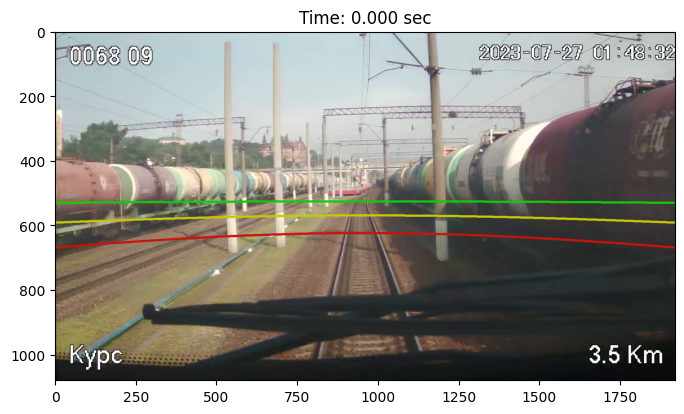

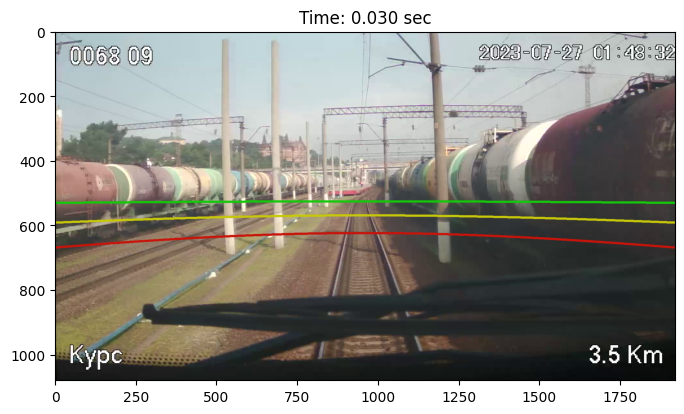

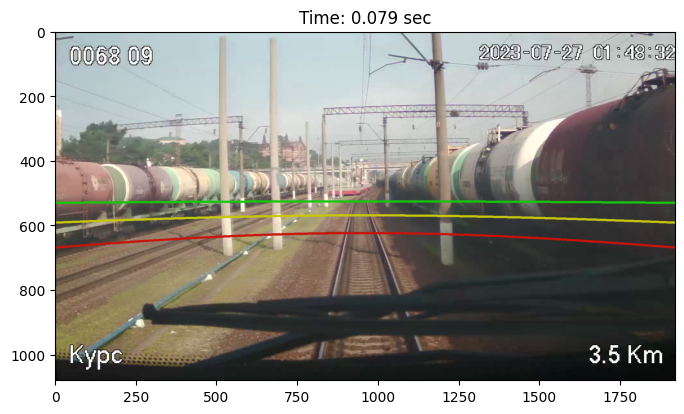

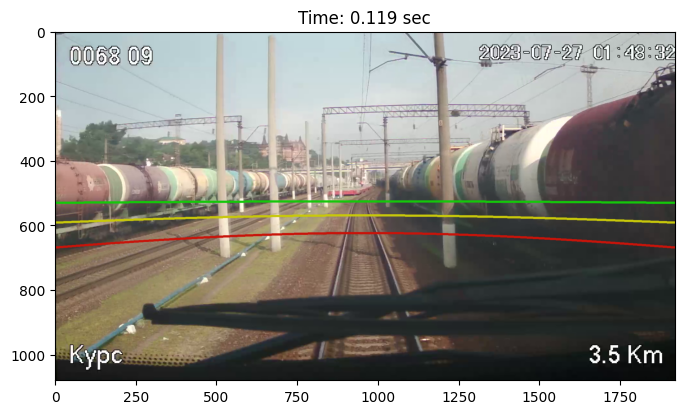

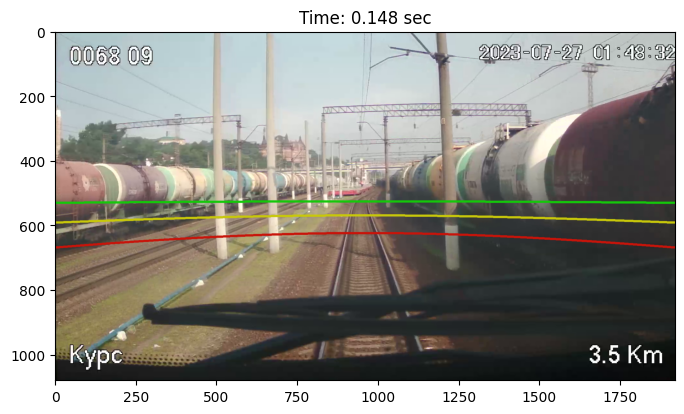

In [5]:
save_folder = '/media/alexey/HDDData/datasets/railway/RZD_Alarm/frames/04_30_12/'
os.makedirs(save_folder, exist_ok=True)

exp_frame = None

for _ in tqdm(range(5)):
    grap, frame = stream.read()
    
    if not grap:
        break
        
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    exp_frame = frame.copy()

    frame = draw_lines(frame, K, angle, dists, camera_h)
    timestamp = stream.get(cv2.CAP_PROP_POS_MSEC) / 1000.0

    plot_frame(frame, title='Time: {:.3f} sec'.format(timestamp))
    # cv2.imwrite(save_folder + '{:.3f}.png'.format(timestamp), cv2.cvtColor(frame, cv2.COLOR_RGB2BGR))
    
plt.show()

# stream.release()

960 1920


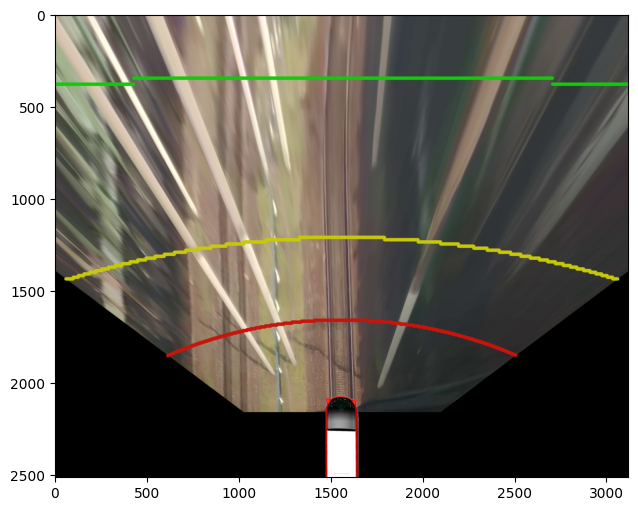

In [40]:
print(exp_frame.shape[1] // 2, exp_frame.shape[1])
calcle_distance_line
dets = convert_yoloonnx_detections_to_united_list(yolo_model(exp_frame))
dets = [det for det in dets if det[2] == 0]

dst_points = [
    [0, 0],
    [exp_frame.shape[1] - 1, 0],
    [exp_frame.shape[1] - 1, exp_frame.shape[0] * 4 - 1],
    [0, exp_frame.shape[0] * 4 - 1],
]

d1 = 135
d2 = 100

shift_of_view = exp_frame.shape[0]

src_points = [
    [960 - d1, 518],
    [960 + d1, 518],
    [1920 - d2, 830],
    [d2, 830]
]

dst_points = np.array(dst_points, np.float32) / 2
src_points = np.array(src_points, np.float32)

dst_points[:, 0] += shift_of_view

mat = cv2.getPerspectiveTransform(src_points, dst_points)
warp_size = (exp_frame.shape[1] // 2 + shift_of_view * 2, exp_frame.shape[0] * 2)

# line1 = calcle_distance_line(dists[0], exp_frame.shape[:2], camera_h, K, transform_to_formula_angle(angle))
# line1_points = np.array([[x, line1[x]] for x in range(len(line1))])
# line1_pts = line1_points.astype(np.float32)[:, None]
# warped_line1_pts = cv2.perspectiveTransform(line1_pts, mat).squeeze(1)

dist_info = {
    'K': K,
    'angle': transform_to_formula_angle(angle),
    'h': camera_h,
    'distances': dists
}

# out = cv2.warpPerspective(exp_frame.copy(), mat, warp_size)
out = render_dist_frame(exp_frame, train_model, mat, warp_size, dets, dist_info)
res_size = out.shape[:2]

plot_frame(out)
plt.show()

In [25]:
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
video_writer = cv2.VideoWriter(
    '/media/alexey/HDDData/datasets/railway/RZD_Alarm/output.mp4', fourcc, 
    fps, 
    res_size[::-1]
)

for i in tqdm(range(500)):    
    grap, frame = stream.read()
    
    if not grap:
        break
        
    if i < 200:
        continue
        
    dets = convert_yoloonnx_detections_to_united_list(yolo_model(frame))
    dets = [det for det in dets if det[2] == 0]
        
    out = render_dist_frame(
        frame, cv2.cvtColor(train_model, cv2.COLOR_RGBA2BGRA), mat, warp_size,
        dets, dist_info
    )
    video_writer.write(out)
    
stream.release()
video_writer.release()

  0%|          | 0/500 [00:00<?, ?it/s]